# Решение трека №1

* Участник: Мелентьев Никита
* Команда: 101-team

------------------------------

**Используемые файлы:**
* Папка ./data - с данными
* Папка ./results - с результатами
* Файл utils.py - код с вспомогательными функциями
* Файл main.ipynb - скрипт для обучения модели и расчета сабмита

## Imports

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool, cv

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')
import utils

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

## Data Load

**Target**

In [3]:
target_train_df = pd.read_csv('./data/target_train.csv')
sub_df = pd.read_csv('./data/sample_submission.csv')

print('Train shape:', target_train_df.shape[0])
print('Test shape:', sub_df.shape[0])

# Проверим что трейн / тест не пересекаются по id
assert len(set(sub_df.NPLV.unique()).intersection(target_train_df.NPLV.unique())) == 0

target_train_df.head(3)

Train shape: 2063
Test shape: 780


,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091


**Chronom**

In [4]:
chronom_train_df = pd.read_csv('./data/chronom_train.csv',index_col = 0)
chronom_test_df = pd.read_csv('./data/chronom_test.csv',index_col = 0)

# Типизация
chronom_train_df.VR_NACH = pd.to_datetime(chronom_train_df.VR_NACH)
chronom_test_df.VR_NACH = pd.to_datetime(chronom_test_df.VR_NACH)
chronom_train_df.VR_KON = pd.to_datetime(chronom_train_df.VR_KON)
chronom_test_df.VR_KON = pd.to_datetime(chronom_test_df.VR_KON)

# Уберем баг с 2011
chronom_train_df = chronom_train_df[chronom_train_df.VR_NACH.dt.year == 2021].copy()
chronom_test_df = chronom_test_df[chronom_test_df.VR_NACH.dt.year == 2021].copy()

# Закодируем марку
le = LabelEncoder()
chronom_train_df['NOP_le'] = le.fit_transform(chronom_train_df['NOP'])
le_dict = dict(zip(le.classes_, np.arange(len(le.classes_))))
chronom_test_df['NOP_le'] = chronom_test_df['NOP'].map(lambda x: le_dict.get(x, -1)).astype('int64')

chronom_train_df.head(3)

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,NOP_le
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN,33
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN,17
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN,8


**Produv**

In [6]:
produv_train_df = pd.read_csv('./data/produv_train.csv')
produv_test_df = pd.read_csv('./data/produv_test.csv')

# Типизация
produv_train_df.SEC = pd.to_datetime(produv_train_df.SEC)
produv_test_df.SEC = pd.to_datetime(produv_test_df.SEC)

# Сортировка
produv_train_df = produv_train_df.sort_values(['NPLV', 'SEC']).reset_index(drop = True)
produv_test_df = produv_test_df.sort_values(['NPLV', 'SEC']).reset_index(drop = True)

# Проверка совпадения id с train / test
assert len(set(produv_train_df.NPLV.unique()).intersection(target_train_df.NPLV.unique())) == target_train_df.NPLV.nunique()
assert produv_train_df.NPLV.nunique() == target_train_df.NPLV.nunique()
assert len(set(produv_test_df.NPLV.unique()).intersection(sub_df.NPLV.unique())) == sub_df.NPLV.nunique()
assert produv_test_df.NPLV.nunique() == sub_df.NPLV.nunique()

# Оставим только время продувки (на основе хронометража)
produv_train_df = produv_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV', 'VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
produv_test_df = produv_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_NACH', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
produv_train_df = produv_train_df[(produv_train_df.SEC >= produv_train_df.VR_NACH)&
               (produv_train_df.SEC <= produv_train_df.VR_KON)]\
    .drop(['VR_NACH', 'VR_KON'], 1)
produv_test_df = produv_test_df[(produv_test_df.SEC >= produv_test_df.VR_NACH)&
               (produv_test_df.SEC <= produv_test_df.VR_KON)]\
    .drop(['VR_NACH', 'VR_KON'], 1)

# расход в минуту -> расход в секунду
produv_train_df['RAS'] = produv_train_df['RAS'] / 60
produv_test_df['RAS'] = produv_test_df['RAS'] / 60
produv_train_df = utils.min_to_sec(produv_train_df)
produv_test_df = utils.min_to_sec(produv_test_df)

# новые признаки
produv_train_df['RAS_MUL_POL'] = produv_train_df['RAS'] * produv_train_df['POL']
produv_test_df['RAS_MUL_POL'] = produv_test_df['RAS'] * produv_test_df['POL']
produv_train_df['RAS_REL_POL'] = produv_train_df['RAS'] / produv_train_df['POL']
produv_test_df['RAS_REL_POL'] = produv_test_df['RAS'] / produv_test_df['POL']

produv_train_df.head(3)

,NPLV,SEC,RAS,POL,RAS_MUL_POL,RAS_REL_POL
0,510008.0,2021-01-01 03:18:26,6.366667,3.92,24.957333,1.62415
1,510008.0,2021-01-01 03:18:27,6.366667,3.92,24.957333,1.62415
2,510008.0,2021-01-01 03:18:28,6.366667,3.92,24.957333,1.62415


**Lom**

In [7]:
lom_train_df = pd.read_csv('./data/lom_train.csv')
lom_test_df = pd.read_csv('./data/lom_test.csv')

# Для категориальных фичей
lom_train_df['VDL'] = 'VDL_' + lom_train_df['VDL'].astype('str')
lom_test_df['VDL'] = 'VDL_' + lom_test_df['VDL'].astype('str')

# Проверка на совпадение id с трейн / тестом
assert len(set(lom_train_df.VDL.unique()).union(lom_test_df.VDL.unique())) == len(lom_train_df.VDL.unique())
assert lom_train_df[lom_train_df.duplicated(['NPLV', 'VDL'])].shape[0] == 0

lom_train_df.head(3)

,NPLV,VDL,NML,VES
0,510008,VDL_4,К,56500
1,510008,VDL_8,О,16700
2,510008,VDL_13,КП,3000


**Plavki info**

In [8]:
plavki_train_df = pd.read_csv('./data/plavki_train.csv')
plavki_test_df = pd.read_csv('./data/plavki_test.csv')

# Типизация
plavki_train_df['plavka_VR_NACH'] = pd.to_datetime(plavki_train_df['plavka_VR_NACH'])
plavki_train_df['plavka_VR_KON'] = pd.to_datetime(plavki_train_df['plavka_VR_KON'])
plavki_test_df['plavka_VR_NACH'] = pd.to_datetime(plavki_test_df['plavka_VR_NACH'])
plavki_test_df['plavka_VR_KON'] = pd.to_datetime(plavki_test_df['plavka_VR_KON'])

# Удаление багов с дуплями
plavki_train_df = plavki_train_df[~plavki_train_df.duplicated(['NPLV'], keep = 'first')].reset_index(drop = True)
plavki_test_df = plavki_test_df[~plavki_test_df.duplicated(['NPLV'], keep = 'first')].reset_index(drop = True)

# Для категориальных фичей кодируем марку
le = LabelEncoder()
plavki_train_df['plavka_NMZ'] = le.fit_transform(plavki_train_df['plavka_NMZ'])
le_dict = dict(zip(le.classes_, np.arange(len(le.classes_))))
plavki_test_df['plavka_NMZ'] = plavki_test_df['plavka_NMZ'].map(lambda x: le_dict.get(x, -1))

plavki_train_df.head(3)

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,42,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,42,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,58,Изл,973,цилиндрическая,13,5 сопловая,13


**sip**

In [9]:
sip_train_df = pd.read_csv('./data/sip_train.csv')
sip_test_df = pd.read_csv('./data/sip_test.csv')

# Типизация
sip_train_df['DAT_OTD'] = pd.to_datetime(sip_train_df['DAT_OTD'])
sip_test_df['DAT_OTD'] = pd.to_datetime(sip_test_df['DAT_OTD'])

# Для категориальных фичей кодируем вид
sip_train_df['VDSYP'] = 'VDSYP_' + sip_train_df['VDSYP'].astype('str')
sip_test_df['VDSYP'] = 'VDSYP_' + sip_test_df['VDSYP'].astype('str')

# Оставим только время продувки (на основе хронометража)
sip_train_df = sip_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV','VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
sip_test_df = sip_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
sip_train_df = sip_train_df[sip_train_df['DAT_OTD'] <= sip_train_df['VR_KON']].copy()
sip_test_df = sip_test_df[sip_test_df['DAT_OTD'] <= sip_test_df['VR_KON']].copy()

sip_train_df.head(3)

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD,VR_KON
0,510008,VDSYP_346,Уголь ТО,570,2021-01-01 03:03:53,2021-01-01 03:37:55
1,510008,VDSYP_346,Уголь ТО,220,2021-01-01 03:04:10,2021-01-01 03:37:55
2,510008,VDSYP_408,изв_ЦОИ,7300,2021-01-01 03:08:17,2021-01-01 03:37:55


**chugun**

In [10]:
chugun_train_df = pd.read_csv('./data/chugun_train.csv')
chugun_test_df = pd.read_csv('./data/chugun_test.csv')

# Типизация
chugun_train_df['DATA_ZAMERA'] = pd.to_datetime(chugun_train_df['DATA_ZAMERA'])
chugun_test_df['DATA_ZAMERA'] = pd.to_datetime(chugun_test_df['DATA_ZAMERA'])

chugun_train_df.head(3)

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40


**gas**



In [14]:
gas_train_df = pd.read_csv('./data/gas_train.csv')
gas_test_df = pd.read_csv('./data/gas_test.csv')

# Типизация
gas_train_df['Time'] = pd.to_datetime(gas_train_df['Time'])
gas_test_df['Time'] = pd.to_datetime(gas_test_df['Time'])

# Оставим только время продувки (на основе хронометража)
gas_train_df = gas_train_df.merge(
    chronom_train_df[chronom_train_df.NOP == 'Продувка'][['NPLV','VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
gas_test_df = gas_test_df.merge(
    chronom_test_df[chronom_test_df.NOP == 'Продувка'][['NPLV', 'VR_KON']],
    on = ['NPLV'], how = 'left', validate = 'm:1'
)
gas_train_df = gas_train_df[gas_train_df['Time'] <= gas_train_df['VR_KON']].copy()
gas_test_df = gas_test_df[gas_test_df['Time'] <= gas_test_df['VR_KON']].copy()

# Новая фича
gas_train_df['T_rel'] = gas_train_df['T'] / gas_train_df['V'] 
gas_test_df['T_rel'] = gas_test_df['T'] / gas_test_df['V'] 

gas_train_df.head(3)

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure,VR_KON,T_rel
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938,2021-01-01 03:37:55,0.001204
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938,2021-01-01 03:37:55,0.001204
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938,2021-01-01 03:37:55,0.001201


## Features

In [194]:
# Какие фичи в целом собирать для данных
used_features = [
    
    # Суммы
    'VDL_SUM','VDSYP_SUM',
    
    # Фичи продувки
    'NPLV_SUM_RAS', 'NPLV_MEDIAN_RAS', 'NPLV_MEAN_RAS', 'NPLV_STD_RAS', 'NPLV_MIN_RAS', 'NPLV_MAX_RAS',
    'NPLV_SUM_POL', 'NPLV_MEDIAN_POL', 'NPLV_MEAN_POL', 'NPLV_STD_POL', 'NPLV_MIN_POL', 'NPLV_MAX_POL',
    'NPLV_MEAN_RAS_MUL_POL', 'NPLV_MEAN_RAS_REL_POL',
#     'NPLV_SUM_RAS_MUL_POL', 'NPLV_MEDIAN_RAS_MUL_POL', 'NPLV_MEAN_RAS_MUL_POL', 'NPLV_STD_RAS_MUL_POL', 'NPLV_MIN_RAS_MUL_POL', 'NPLV_MAX_RAS_MUL_POL',
#     'NPLV_SUM_RAS_REL_POL', 'NPLV_MEDIAN_RAS_REL_POL', 'NPLV_MEAN_RAS_REL_POL', 'NPLV_STD_RAS_REL_POL', 'NPLV_MIN_RAS_REL_POL', 'NPLV_MAX_RAS_REL_POL',
    'NPLV_total_seconds', 'NPLV_TIME_SINCE_LAST', 
    
    # Фичи плавки
    'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL',
#     'plavka_ST_FURM', 'plavka_ST_GOL', # 'plavka_NMZ' (OK),
    
    # Фичи чугуна
    'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU', 'V', 'TI', 'CHUGUN_SINCE_ZAME_SECONDS', #'VES',#'T', #
    
    # Комбинированные фичи
#     'VES_CHUGUN_REL_LOM', 'VES_CHUGUN_SUM_LOM', 'VES_CHUGUN_REL_SIP','VES_CHUGUN_SUM_SIP', 'VES_CHUGUN_SUM_SIP_LOM',
    
    
    # Фичи газа
    'T_last_gas',  'V_last_gas', 'O2_last_gas', 'N2_last_gas', 'H2_last_gas', 'CO2_last_gas', 'CO_last_gas', 'AR_last_gas',
    'O2_mean_gas', 'N2_mean_gas', 'H2_mean_gas', 'CO2_mean_gas', 'CO_mean_gas', 'AR_mean_gas', 'T фурмы 1_mean_gas', 'T фурмы 2_mean_gas', 'O2_pressure_mean_gas',
#     'V_sum_gas', 'T_rel_last_gas', 'T_mean_gas', 'T_rel_mean_gas', 'V_mean_gas',
    
    # Другие фичи
    'HAS_DODUVKA_T', 'HAS_DODUVKA_C',
    'PLAVKI_O2', 'TIME_FROM_PLAVKI_TO_PRODUV', # 'TIME_FROM_START_TO_PRODUV', 'OPERATIONS_COUNT_TO_PRODUV'
    
    # Другие фичи
#     '0_CHRONO_NOP', '4_CHRONO_NOP', '5_CHRONO_NOP', '6_CHRONO_NOP', '7_CHRONO_NOP', '8_CHRONO_NOP', 
#     '9_CHRONO_NOP', '10_CHRONO_NOP', '11_CHRONO_NOP', '12_CHRONO_NOP', '13_CHRONO_NOP', '14_CHRONO_NOP', 
#     '16_CHRONO_NOP', '17_CHRONO_NOP', '19_CHRONO_NOP', '20_CHRONO_NOP', '21_CHRONO_NOP', '22_CHRONO_NOP', 
#     '24_CHRONO_NOP', '26_CHRONO_NOP', '27_CHRONO_NOP', '29_CHRONO_NOP', '30_CHRONO_NOP', '32_CHRONO_NOP', 
#     '33_CHRONO_NOP',
    
] + list(lom_train_df.VDL.unique())\
    + list(sip_train_df.VDSYP.unique()) # фичи лома / материалов
# [x + '_REL' for x in list(sip_train_df.VDSYP.unique())]

cat_features = ['plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL']
target_feature_1 = 'TST'
target_feature_2 = 'C'

**Соберем фичи**

In [195]:
# TRAIN
train_df = target_train_df.copy()
train_df = utils.prepare_features(train_df, produv_train_df, lom_train_df, 
                            plavki_train_df, sip_train_df, chugun_train_df, 
                            gas_train_df, chronom_train_df, used_features)\
    [used_features + ['NPLV', target_feature_1, target_feature_2]]
assert train_df.shape[0] == target_train_df.shape[0]

# TEST
test_df = sub_df.copy()
test_df = utils.prepare_features(test_df, produv_test_df, lom_test_df, 
                           plavki_test_df, sip_test_df, chugun_test_df, 
                           gas_test_df, chronom_test_df, used_features)\
    [used_features + ['NPLV', target_feature_1, target_feature_2]]
assert test_df.shape[0] == sub_df.shape[0]

train_df.head()

,VDL_SUM,VDSYP_SUM,NPLV_SUM_RAS,NPLV_MEDIAN_RAS,NPLV_MEAN_RAS,NPLV_STD_RAS,NPLV_MIN_RAS,NPLV_MAX_RAS,NPLV_SUM_POL,NPLV_MEDIAN_POL,NPLV_MEAN_POL,NPLV_STD_POL,NPLV_MIN_POL,NPLV_MAX_POL,NPLV_MEAN_RAS_MUL_POL,NPLV_MEAN_RAS_REL_POL,NPLV_total_seconds,NPLV_TIME_SINCE_LAST,plavka_NAPR_ZAD,plavka_TIPE_FUR,plavka_TIPE_GOL,SI,MN,S,P,CR,NI,CU,V,TI,CHUGUN_SINCE_ZAME_SECONDS,T_last_gas,V_last_gas,O2_last_gas,N2_last_gas,H2_last_gas,CO2_last_gas,CO_last_gas,AR_last_gas,O2_mean_gas,N2_mean_gas,H2_mean_gas,CO2_mean_gas,CO_mean_gas,AR_mean_gas,T фурмы 1_mean_gas,T фурмы 2_mean_gas,O2_pressure_mean_gas,HAS_DODUVKA_T,HAS_DODUVKA_C,PLAVKI_O2,TIME_FROM_PLAVKI_TO_PRODUV,VDL_4,VDL_8,VDL_13,VDL_23,VDL_61,VDL_20,VDL_48,VDL_49,VDL_63,VDL_3,VDSYP_346,VDSYP_408,VDSYP_171,VDSYP_442,VDSYP_104,VDSYP_119,VDSYP_397,NPLV,TST,C
0,76200.0,20970.0,16240.172271,13.840876,13.892363,1.676171,1.233333,16.083333,1335.281393,0.861364,1.142242,0.773493,0.77,7.070000,15.316885,14.785282,1168.0,NaN,2,1,1,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,203.0,788.888855,228116.281250,9.06,78.139999,0.00,11.210000,0.610000,0.98,7.625880,53.331026,0.433692,14.753185,23.186775,0.722656,0.0,0.0,13.275444,NaN,NaN,2909.0,614.0,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2950.0,14080.0,980.0,2960.0,0.0,0.0,0.0,510008,1690,0.060
1,78600.0,23780.0,17030.273545,13.256468,13.857017,2.100884,1.133333,17.100000,1659.173624,0.840625,1.350019,0.918433,0.63,4.760000,19.134821,13.716225,1228.0,4110.0,2,1,1,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,188.0,849.652771,218898.750000,5.35,77.190002,0.00,15.480000,0.980000,0.99,13.377855,59.509808,0.232710,10.184671,15.924699,0.773789,0.0,0.0,14.234425,NaN,NaN,2182.0,1570.0,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2930.0,18830.0,960.0,0.0,1060.0,0.0,0.0,510009,1683,0.097
2,76300.0,24070.0,16757.740094,13.368033,13.679788,1.796618,1.200000,17.150000,1549.260352,0.802623,1.264702,0.899005,0.65,4.080235,17.403474,14.416840,1224.0,3494.0,3,1,1,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,210.0,843.750000,224639.625000,8.70,79.639999,0.02,9.970000,0.650000,1.01,8.766427,54.767072,0.448505,13.996761,21.280526,0.745038,0.0,0.0,13.974222,NaN,NaN,2841.0,759.0,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,2990.0,16080.0,1050.0,2960.0,990.0,0.0,0.0,510010,1662,0.091
3,84100.0,17930.0,14200.966667,13.054092,13.435162,1.833840,1.283333,16.466667,1518.655000,1.094894,1.436760,1.013042,0.79,11.180000,18.580853,11.680728,1056.0,3522.0,3,1,1,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,175.0,828.472229,222569.171875,0.00,47.000000,0.06,23.309999,28.959999,0.68,8.251735,53.585633,0.184917,14.258167,22.783701,0.710997,0.0,0.0,13.906455,NaN,NaN,10.0,603.0,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3620.0,14310.0,0.0,0.0,0.0,0.0,0.0,510011,1609,0.410
4,76100.0,26470.0,16786.875000,13.056206,13.548729,1.778447,1.033333,16.583333,1418.405000,0.800000,1.144798,0.758379,0.67,5.000000,15.521455,14.646443,1238.0,3734.0,1,1,1,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,184.0,813.194397,225770.281250,6.05,79.959999,0.02,12.290000,0.700000,0.98,8.183483,55.507625,0.645989,14.068245,20.743848,0.730457,0.0,0.0,14.063802,1.0,NaN,2131.0,741.0,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2930.0,17480.0,1000.0,3010.0,2050.0,0.0,0.0,510012,1682,0.120


## Model

In [196]:
# Общие параметры модели
params = {
    "iterations": 10000,
    "loss_function": "MAE",
    'learning_rate':0.01,
    "verbose": 100,
    'random_seed':42,
}

# Для каждой модели отдельный датасет
train_df_1 = train_df.copy()
train_df_2 = train_df[~pd.isnull(train_df['C'])].copy()
train_size_1 = int(train_df_1.shape[0] * 0.8)
train_size_2 = int(train_df_2.shape[0] * 0.8)

**model 1 - TST**

In [197]:
# Фичи модели
used_features_1 = [x for x in used_features if 'HAS_DODUVKA' not in x ]
cat_features_1 = cat_features

# Данные модели
X_1 = train_df_1[used_features_1].copy()
X_test_1 = test_df[used_features_1].copy()
y_1 = train_df_1[target_feature_1]

# Данные holdout train / val
X_train_1 = X_1[:train_size_1].copy()
y_train_1 = y_1[:train_size_1].copy()
X_val_1 = X_1[train_size_1:].copy()
y_val_1 = y_1[train_size_1:].copy()

# Обучение
model_1 = CatBoostRegressor(
    iterations=params['iterations'],
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_1,
)
model_1.fit(X_train_1, y_train_1,
         eval_set=Pool(X_val_1, y_val_1, cat_features=cat_features_1),
         early_stopping_rounds=100,
         use_best_model=True,);
y_train_pred_1 = model_1.predict(X_train_1)
y_val_pred_1 = model_1.predict(X_val_1)
y_test_pred_1 = model_1.predict(X_test_1)
    
# Ошибки модели
print('Train MAE TST:', mean_absolute_error(y_train_1, y_train_pred_1))
print('VAL MAE TST:', mean_absolute_error(y_val_1, y_val_pred_1))
print('Best it TEST:', model_1.best_iteration_)

Train MAE TST: 17.05664471921746
VAL MAE TST: 17.376628130289134
Best it TEST: 409


+ drop plavka_ST_FURM / plavka_ST_GOL
Train MAE TST: 17.05664471921746
VAL MAE TST: 17.376628130289134
Best it TEST: 409

Train MAE TST: 18.079242489169953
VAL MAE TST: 17.39128590842601
Best it TEST: 302

In [198]:
# utils.plot_feature_importance(model_1.get_feature_importance(), used_features_2,'CATBOOST ')

In [199]:
# Фичи модели
used_features_2 = [x for x in used_features if 'HAS_DODUVKA' not in x]
cat_features_2 = cat_features

# Данные модели
X_2 = train_df_2[used_features_2].copy()
X_test_2 = test_df[used_features_2].copy()
y_2 = train_df_2[target_feature_2]

# Данные holdout train / val
X_train_2 = X_2[:train_size_2].copy()
y_train_2 = y_2[:train_size_2].copy()
X_val_2 = X_2[train_size_2:].copy()
y_val_2 = y_2[train_size_2:].copy()

# Обучение
model_2 = CatBoostRegressor(
    iterations=params['iterations'],
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_2,
)
model_2.fit(X_train_2, y_train_2,
         eval_set=Pool(X_val_2, y_val_2, cat_features=cat_features_2),
         early_stopping_rounds=100,
         use_best_model=True);
y_train_pred_2 = model_2.predict(X_train_2)
y_val_pred_2 = model_2.predict(X_val_2)
y_test_pred_2 = model_2.predict(X_test_2)

# Ошибки модели
print('Train MAE C:', mean_absolute_error(y_train_2, y_train_pred_2))
print('VAL MAE C:', mean_absolute_error(y_val_2, y_val_pred_2))
print('Best it 2:', model_2.best_iteration_)

Train MAE C: 0.02614130455544666
VAL MAE C: 0.03062920305643536
Best it 2: 361


+ drop plavka_ST_FURM / plavka_ST_GOL
Train MAE C: 0.02614130455544666
VAL MAE C: 0.03062920305643536
Best it 2: 361

Train MAE C: 0.02251188503186906
VAL MAE C: 0.030071370527515646
Best it 2: 684

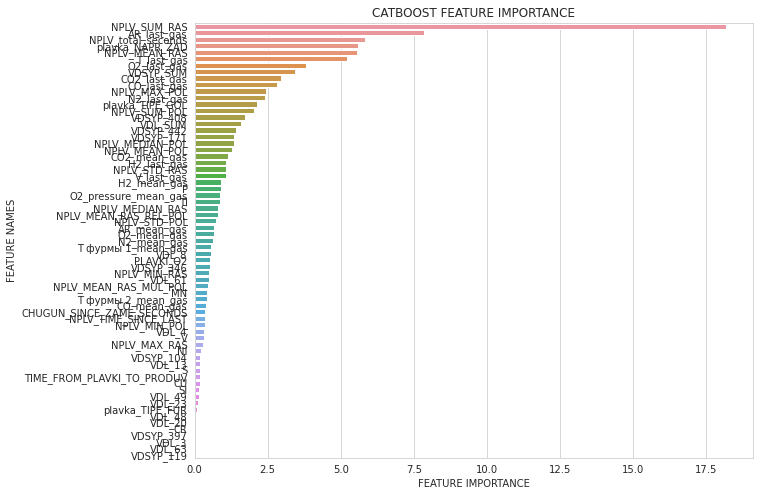

In [200]:
utils.plot_feature_importance(model_2.get_feature_importance(), used_features_2,'CATBOOST ')

## Predict

**Полное обучение моделей**

In [201]:
print('Model 1 iterations:', model_1.best_iteration_)
model_1_full = CatBoostRegressor(
    iterations=model_1.best_iteration_,
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_1,
)
model_1_full.fit(X_1, y_1);
y_test_pred_1_full = model_1_full.predict(X_test_1)

# full train
print('Model 2 iterations:', model_2.best_iteration_)
model_2_full = CatBoostRegressor(
    iterations=model_2.best_iteration_,
    learning_rate=params['learning_rate'],
    loss_function=params['loss_function'],
    verbose=False,
    cat_features = cat_features_2,
)
model_2_full.fit(X_2, y_2);
y_test_pred_2_full = model_2_full.predict(X_test_2)

Model 1 iterations: 409
Model 2 iterations: 361


**Прогноз теста**

In [202]:
# predict
save_df = sub_df.copy()
save_df['TST'] = y_test_pred_1_full
save_df['C'] = y_test_pred_2_full
assert save_df.shape[0] == sub_df.shape[0]
save_df.to_csv('./results/submission_final.csv', index = False)
save_df.head(3)

,NPLV,TST,C
0,512324,1643.979088,0.036826
1,512327,1628.358503,0.074838
2,512328,1652.362062,0.090169
